另外，使用 Jupyter Notebook 进行长期模型训练时，可能由于 GPU 内存无法及时释放导致该报错

In [33]:
from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import tensorflow as tf
import gc

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it does something you should see a number as output

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.compat.v1.Session(config=config))
    

    
'''

dense_layers = [0, 1, 2]
layer_sizes = [32, 64, 128]
conv_layers = [1, 2, 3]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            reset_keras()
            # training your model here
            
'''

'\n\ndense_layers = [0, 1, 2]\nlayer_sizes = [32, 64, 128]\nconv_layers = [1, 2, 3]\n\nfor dense_layer in dense_layers:\n    for layer_size in layer_sizes:\n        for conv_layer in conv_layers:\n            reset_keras()\n            # training your model here\n            \n'

two-class classification (binary classification):
- classify movie reviews as positive or negative, based on the text content of reviews

##### The IMDB Dataset

- a set of 50,000 highly polarized reviews
- split into 25,000 reviews for training and 25,000 reviews for testing, each consisting of 50% negative and 50% positive

never test a model on the same data used to train (it doesn't make sense)

preprocess the sequences of words into sequences of integers, where each integer stands for a specific word in a dictionary

In [20]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

- 'num_words=10000' means keep the top 10,000 most frequently words
- 'train_data' and 'test_data' are lists of reviews of word indices (encoding a sequence of words)
- 'train_labels' and 'test_labels' are list of 0s and 1s, for negative and positive

In [21]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [13]:
train_labels[0]

1

In [14]:
max([max(sequence) for sequence in train_data])

9999

decode to English words:

In [23]:
word_index = imdb.get_word_index()
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join(
    [reverse_word_index.get(i - 3, ' ') for i in train_data[0]])

In [24]:
print(decoded_review)

  this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert   is an amazing actor and now the same being director   father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for   and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also   to the two little boy's that played the   of norman and paul they were just brilliant children are often left out of the   list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

##### Preparing the Data

neural network only accept lists of tensors:
- pad the lists into same length, turn them into integer tensor of shape '(samples, word_indices)', and then use as the first layer in the network handling such integer tensors (the Embedding layer)
- alternatively, one-hot encode the lists into vectors of 0s and 1s, then use as the first layer a Dense layer, capable of handling floating-point vector data

In [22]:
# encoding the integer sequences into a binary matrix
import numpy as np

def vectorize_sequences(sequences, dimension = 10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [23]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [24]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

##### Building the Network

the input data is vectors and the labels are scalars (1s and 0s), so simple stack of fully connected (Dense) layers with 'relu' activations: 'Dense(16, activation='relu')'

the argument being passed to each Dense layer is the number of hidden units of the layer, a 'hidden unit' is a dimension in the representation space of the layer

for each such Dense layer with a relu activation implements the tensor operation:

In [ ]:
output = relu(dot(W, input) + b)

![16 Hidden Unit](./16_hidden_u.png)

![The Network](./the_network.png)

two key architecture decisions of Dense layers:
- how many layers to use
- how many hidden units for each layer

'relu' -- rectified linear unit 
- zero out negative values
![relu](./relu.png)
'sigmoid' 
- squashes arbitrary values into the [0,1] interval outputting as probability
![sigmoid](./sigmoid.png)

In [2]:
# the model definition
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

2022-10-13 10:17:05.943498: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 10:17:06.038893: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 10:17:06.039151: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 10:17:06.040042: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

![Activation Function](./activation_fctn.png)

the loss function and optimizer for binary classification problem here is the 'rmsprop' optimizer and the 'binary_crossentropy' loss function
- crossentropy is a quantity from the field of information theory that measures the distance between probability distributions or, between the ground-truth distribtion and the prediction

In [3]:
# compiling the model
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [4]:
# same compiling but configuring the optimizer
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [5]:
# same compiling but custom losses and metrics
from keras import losses
from keras import metrics

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
             loss=losses.binary_crossentropy,
             metrics=[metrics.binary_accuracy])

##### Validating the Approach

to monitor during training the accuracy, create a validation set by setting apart 10,000 samples from the original training data

In [11]:
# setting aside a validation set
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

then train the model for 20 epochs (20 iterations over all samples in the 'x_train' and 'y_train' tensors), in mini-batches of 512 samples, at the same time, the loss and accuracy will be monitored on the 10,000 samples set apart by passing the validation data as the 'validation_data' argument

In [12]:
# training the model
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=20,
                   batch_size=512,
                   validation_data=(x_val, y_val))

Epoch 1/20


2022-10-13 10:54:01.416515: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


30/30 [==============================] - 3s 33ms/step - loss: 0.5312 - acc: 0.7639 - val_loss: 0.3927 - val_acc: 0.8716
Epoch 2/20
30/30 [==============================] - 0s 16ms/step - loss: 0.3147 - acc: 0.9001 - val_loss: 0.3119 - val_acc: 0.8849
Epoch 3/20
30/30 [==============================] - 1s 18ms/step - loss: 0.2306 - acc: 0.9221 - val_loss: 0.2812 - val_acc: 0.8900
Epoch 4/20
30/30 [==============================] - 1s 17ms/step - loss: 0.1807 - acc: 0.9400 - val_loss: 0.2737 - val_acc: 0.8904
Epoch 5/20
30/30 [==============================] - 1s 17ms/step - loss: 0.1489 - acc: 0.9515 - val_loss: 0.2783 - val_acc: 0.8888
Epoch 6/20
30/30 [==============================] - 0s 17ms/step - loss: 0.1216 - acc: 0.9615 - val_loss: 0.2896 - val_acc: 0.8858
Epoch 7/20
30/30 [==============================] - 0s 17ms/step - loss: 0.1011 - acc: 0.9688 - val_loss: 0.3151 - val_acc: 0.8825
Epoch 8/20
30/30 [==============================] - 1s 17ms/step - loss: 0.0846 - acc: 0.9753 

In [13]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

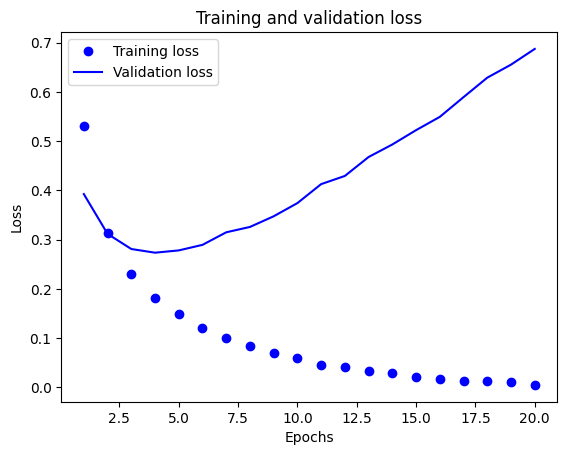

In [16]:
# plotting the training and validation loss
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc = history_dict['acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss') # 'bo' for 'blue dot'
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') # 'b' for 'blue line'
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

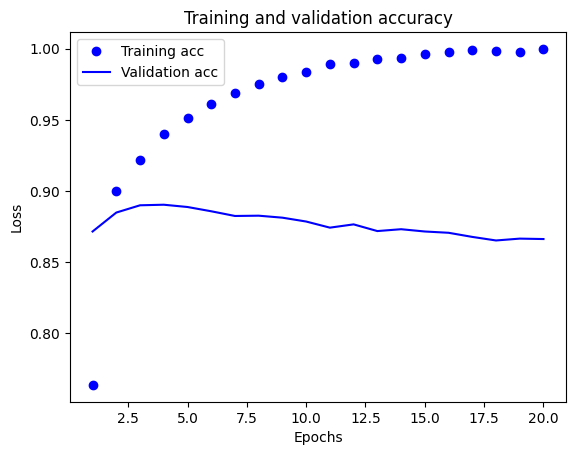

In [17]:
# plotting the training and validation accuracy
plt.clf() # clear the figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

the training loss decreases with every epoch, and the training accuracy increases with every epoch

Gradient Descent Optimisation:
- the quantity to minimise should be less with every iteration

Overfitting:
- a model that performs better on the training data isn't necessarily a model that will do better on data it has never seen before
- in general there are a range of techniques to mitigate overfitting
- here simply stop training after three epochs

In [35]:
# retraining a model from scratch
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

reset_keras()
model.fit(x_train, y_train, epochs=4, batch_size=512)

reset_keras()
results = model.evaluate(x_test, y_test)

2022-10-13 14:48:04.469896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:48:04.470367: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:48:04.470571: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:48:04.470771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:48:04.470905: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

13632
Epoch 1/4
49/49 [==============================] - 1s 11ms/step - loss: 0.4463 - accuracy: 0.8216
Epoch 2/4
49/49 [==============================] - 0s 9ms/step - loss: 0.2562 - accuracy: 0.9101
Epoch 3/4
49/49 [==============================] - 1s 11ms/step - loss: 0.1987 - accuracy: 0.9285
Epoch 4/4
49/49 [==============================] - 0s 10ms/step - loss: 0.1644 - accuracy: 0.9422


2022-10-13 14:48:07.649264: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:48:07.649628: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:48:07.649865: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:48:07.650106: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:48:07.650279: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

766


2022-10-13 14:48:07.976484: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:48:07.976776: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:48:07.976891: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:48:07.977066: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 14:48:07.977167: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

782/782 [==============================] - 3s 4ms/step - loss: 0.2985 - accuracy: 0.8818


In [36]:
results

[0.29845038056373596, 0.8818399906158447]

this fairly naive approach achieves an accuracy of 88%, with state-of-art approoaches, this should be 95%

##### Using a Trained Network to Generate Predictions on New Data

In [37]:
model.predict(x_test)

782/782 [==============================] - 2s 3ms/step


array([[0.22234401],
       [0.9998258 ],
       [0.8431338 ],
       ...,
       [0.1384982 ],
       [0.10944142],
       [0.81987655]], dtype=float32)

##### Further Experiments

the architecture choices have been fairly reasonable, and some potential improvement:
- try one or three hidden layers instead of two and see how affects validation and test accuracy
- try using layers with more hidden units or fewer hidden units: 32 units, 64 units and so on
- try using the 'mse' loss function instead of 'binary_crossentropy'
- try using the 'tanh' activation instead of 'relu'

![Warpping Up](./w_up_3.4.png)